<h1>HW 3 Sample Solution</h1>

The task is the following: Using telecom_Churn.xlsx dataset (on Moodle):
1. [40 points] obtain a model estimating the likelihood of customer churn using Logistic
Regression,
2. [40 points] compare several model evaluation metrics and back up your model selection
decision based on the performance of various measures (e.g. ROC AUC, recall etc.),
3. [20 points] interpret the results of the final logistic regression model.

The steps I followed to complete the analysis and comply with the HW requirements are the following:
1. Descriptive analysis
2. Logistic Regression on raw data
3. Logistic Regression on transformed data
4. Conclusion, selection of the winning model and its interpretation

### Descriptive analysis

Before starting the analysis, we should note that as the assignment requires interpretation of logistic regression coefficient estimates, the analysis would be based on `Logit` from `statsmodels`library. 
The data consists of 3333 observations of 21 variables. The target, **Churn**, is not balanced: there around 85% of customers are staying ("0"), and only 15% are leaving ("1"s.). In my opinion, it is more important to correctly predict the customers who will leave.Therefore, the metrics for choosing the winning model will be **recall score** on testing set.

In [14]:
#importing the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import statsmodels.tools as sm
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

In [15]:
#importing the data and making a dataframe
data=pd.read_excel("Telecom_Churn.xls", sheet_name="churn")

In [16]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
Account Length    3333 non-null int64
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Eve Mins          3333 non-null float64
Night Mins        3333 non-null float64
Intl Mins         3333 non-null float64
CustServ Calls    3333 non-null int64
Churn             3333 non-null int64
Int'l Plan        3333 non-null int64
VMail Plan        3333 non-null int64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
State             3333 non-null object
Area Code         3333 non-null int64
Phone             3333 non-null object
dtypes: float64(8), int64(11), object(2)
memory usage: 546.9+ KB


In [17]:
#have a look at first rows of the dataframe
data.head()

Account Length  VMail Message  Day Mins  Eve Mins  Night Mins  Intl Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ Calls  Churn  Int'l Plan  VMail Plan    ...     Day Charge  \
0               1      0           0           1    ...          45.07   
1               1      0           0           1    ...          27.47   
2               0      0           0           0    ...          41.38   
3               2      0           1           0    ...          50.90   
4               3      0           1           0    ...          28.34   

   Eve Calls  Eve Charge  Night Calls  Night Charge  Intl Calls  Intl Charge  \
0         99       16.78           91         11.01           3         2.70   
1        103       16.62          103         11.45           3         3.70   
2        110       10.30          104          7.32           5         3.29   
3         88        5.26           89          8.86           7         1.78   
4        122       12.61          121          8.41           3         2.73   

   State Area Code     Phone  
0     KS       415  382-4657  
1     OH       415  371-7191  
2     NJ       415  358-1921  
3     OH       408  375-9999  
4     OK       415  330-6626  

[5 rows x 21 columns]

In [18]:
data.describe()

Account Length  VMail Message     Day Mins     Eve Mins   Night Mins  \
count     3333.000000    3333.000000  3333.000000  3333.000000  3333.000000   
mean       101.064806       8.099010   179.775098   200.980348   200.872037   
std         39.822106      13.688365    54.467389    50.713844    50.573847   
min          1.000000       0.000000     0.000000     0.000000    23.200000   
25%         74.000000       0.000000   143.700000   166.600000   167.000000   
50%        101.000000       0.000000   179.400000   201.400000   201.200000   
75%        127.000000      20.000000   216.400000   235.300000   235.300000   
max        243.000000      51.000000   350.800000   363.700000   395.000000   

         Intl Mins  CustServ Calls        Churn   Int'l Plan   VMail Plan  \
count  3333.000000     3333.000000  3333.000000  3333.000000  3333.000000   
mean     10.237294        1.562856     0.144914     0.096910     0.276628   
std       2.791840        1.315491     0.352067     0.295879     0.447398   
min       0.000000        0.000000     0.000000     0.000000     0.000000   
25%       8.500000        1.000000     0.000000     0.000000     0.000000   
50%      10.300000        1.000000     0.000000     0.000000     0.000000   
75%      12.100000        2.000000     0.000000     0.000000     1.000000   
max      20.000000        9.000000     1.000000     1.000000     1.000000   

         Day Calls   Day Charge    Eve Calls   Eve Charge  Night Calls  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.435644    30.562307   100.114311    17.083540   100.107711   
std      20.069084     9.259435    19.922625     4.310668    19.568609   
min       0.000000     0.000000     0.000000     0.000000    33.000000   
25%      87.000000    24.430000    87.000000    14.160000    87.000000   
50%     101.000000    30.500000   100.000000    17.120000   100.000000   
75%     114.000000    36.790000   114.000000    20.000000   113.000000   
max     165.000000    59.640000   170.000000    30.910000   175.000000   

       Night Charge   Intl Calls  Intl Charge    Area Code  
count   3333.000000  3333.000000  3333.000000  3333.000000  
mean       9.039325     4.479448     2.764581   437.182418  
std        2.275873     2.461214     0.753773    42.371290  
min        1.040000     0.000000     0.000000   408.000000  
25%        7.520000     3.000000     2.300000   408.000000  
50%        9.050000     4.000000     2.780000   415.000000  
75%       10.590000     6.000000     3.270000   510.000000  
max       17.770000    20.000000     5.400000   510.000000

In [19]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


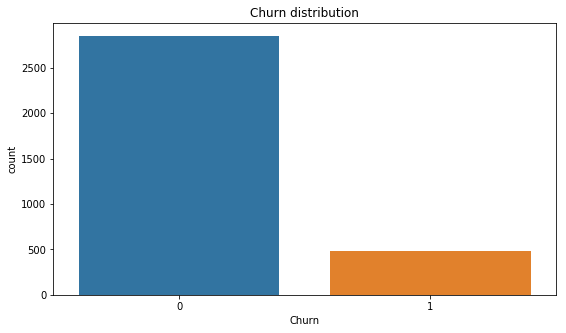

In [20]:
#let's visualise the distribution of churn
plt.figure(figsize=(9,5))
sns.countplot(data.Churn)
plt.title("Churn distribution")
plt.show()

In [21]:
#lets count the benchmark for employee churn
data.Churn.value_counts(normalize=True).mul(100).rename("Churn percentage")

0    85.508551
1    14.491449
Name: Churn percentage, dtype: float64

In [22]:
#Lets see how many unique values there are in the data
data.nunique()

Account Length     212
VMail Message       46
Day Mins          1667
Eve Mins          1611
Night Mins        1591
Intl Mins          162
CustServ Calls      10
Churn                2
Int'l Plan           2
VMail Plan           2
Day Calls          119
Day Charge        1667
Eve Calls          123
Eve Charge        1440
Night Calls        120
Night Charge       933
Intl Calls          21
Intl Charge        162
State               51
Area Code            3
Phone             3333
dtype: int64

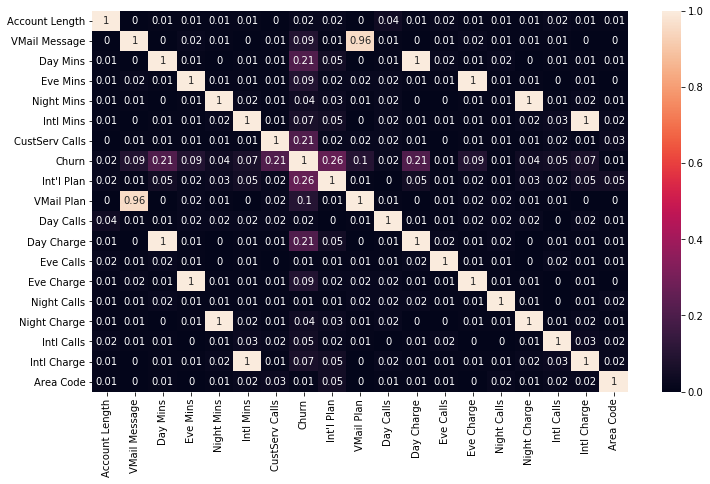

In [23]:
#Let's see the heatmap
plt.figure(figsize=(12,7))
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

As it can be seen, the highest correlation is between VMail Plan and Vmail message, so we will drop one of them, i.e. VMail.

In [24]:
#State and Phone have a lot of values, which cannot be somehow grouped and will result in a lot of dummy columns.
#So we will drop them too.
data.drop(["State","Phone","VMail Plan"], axis=1, inplace=True)

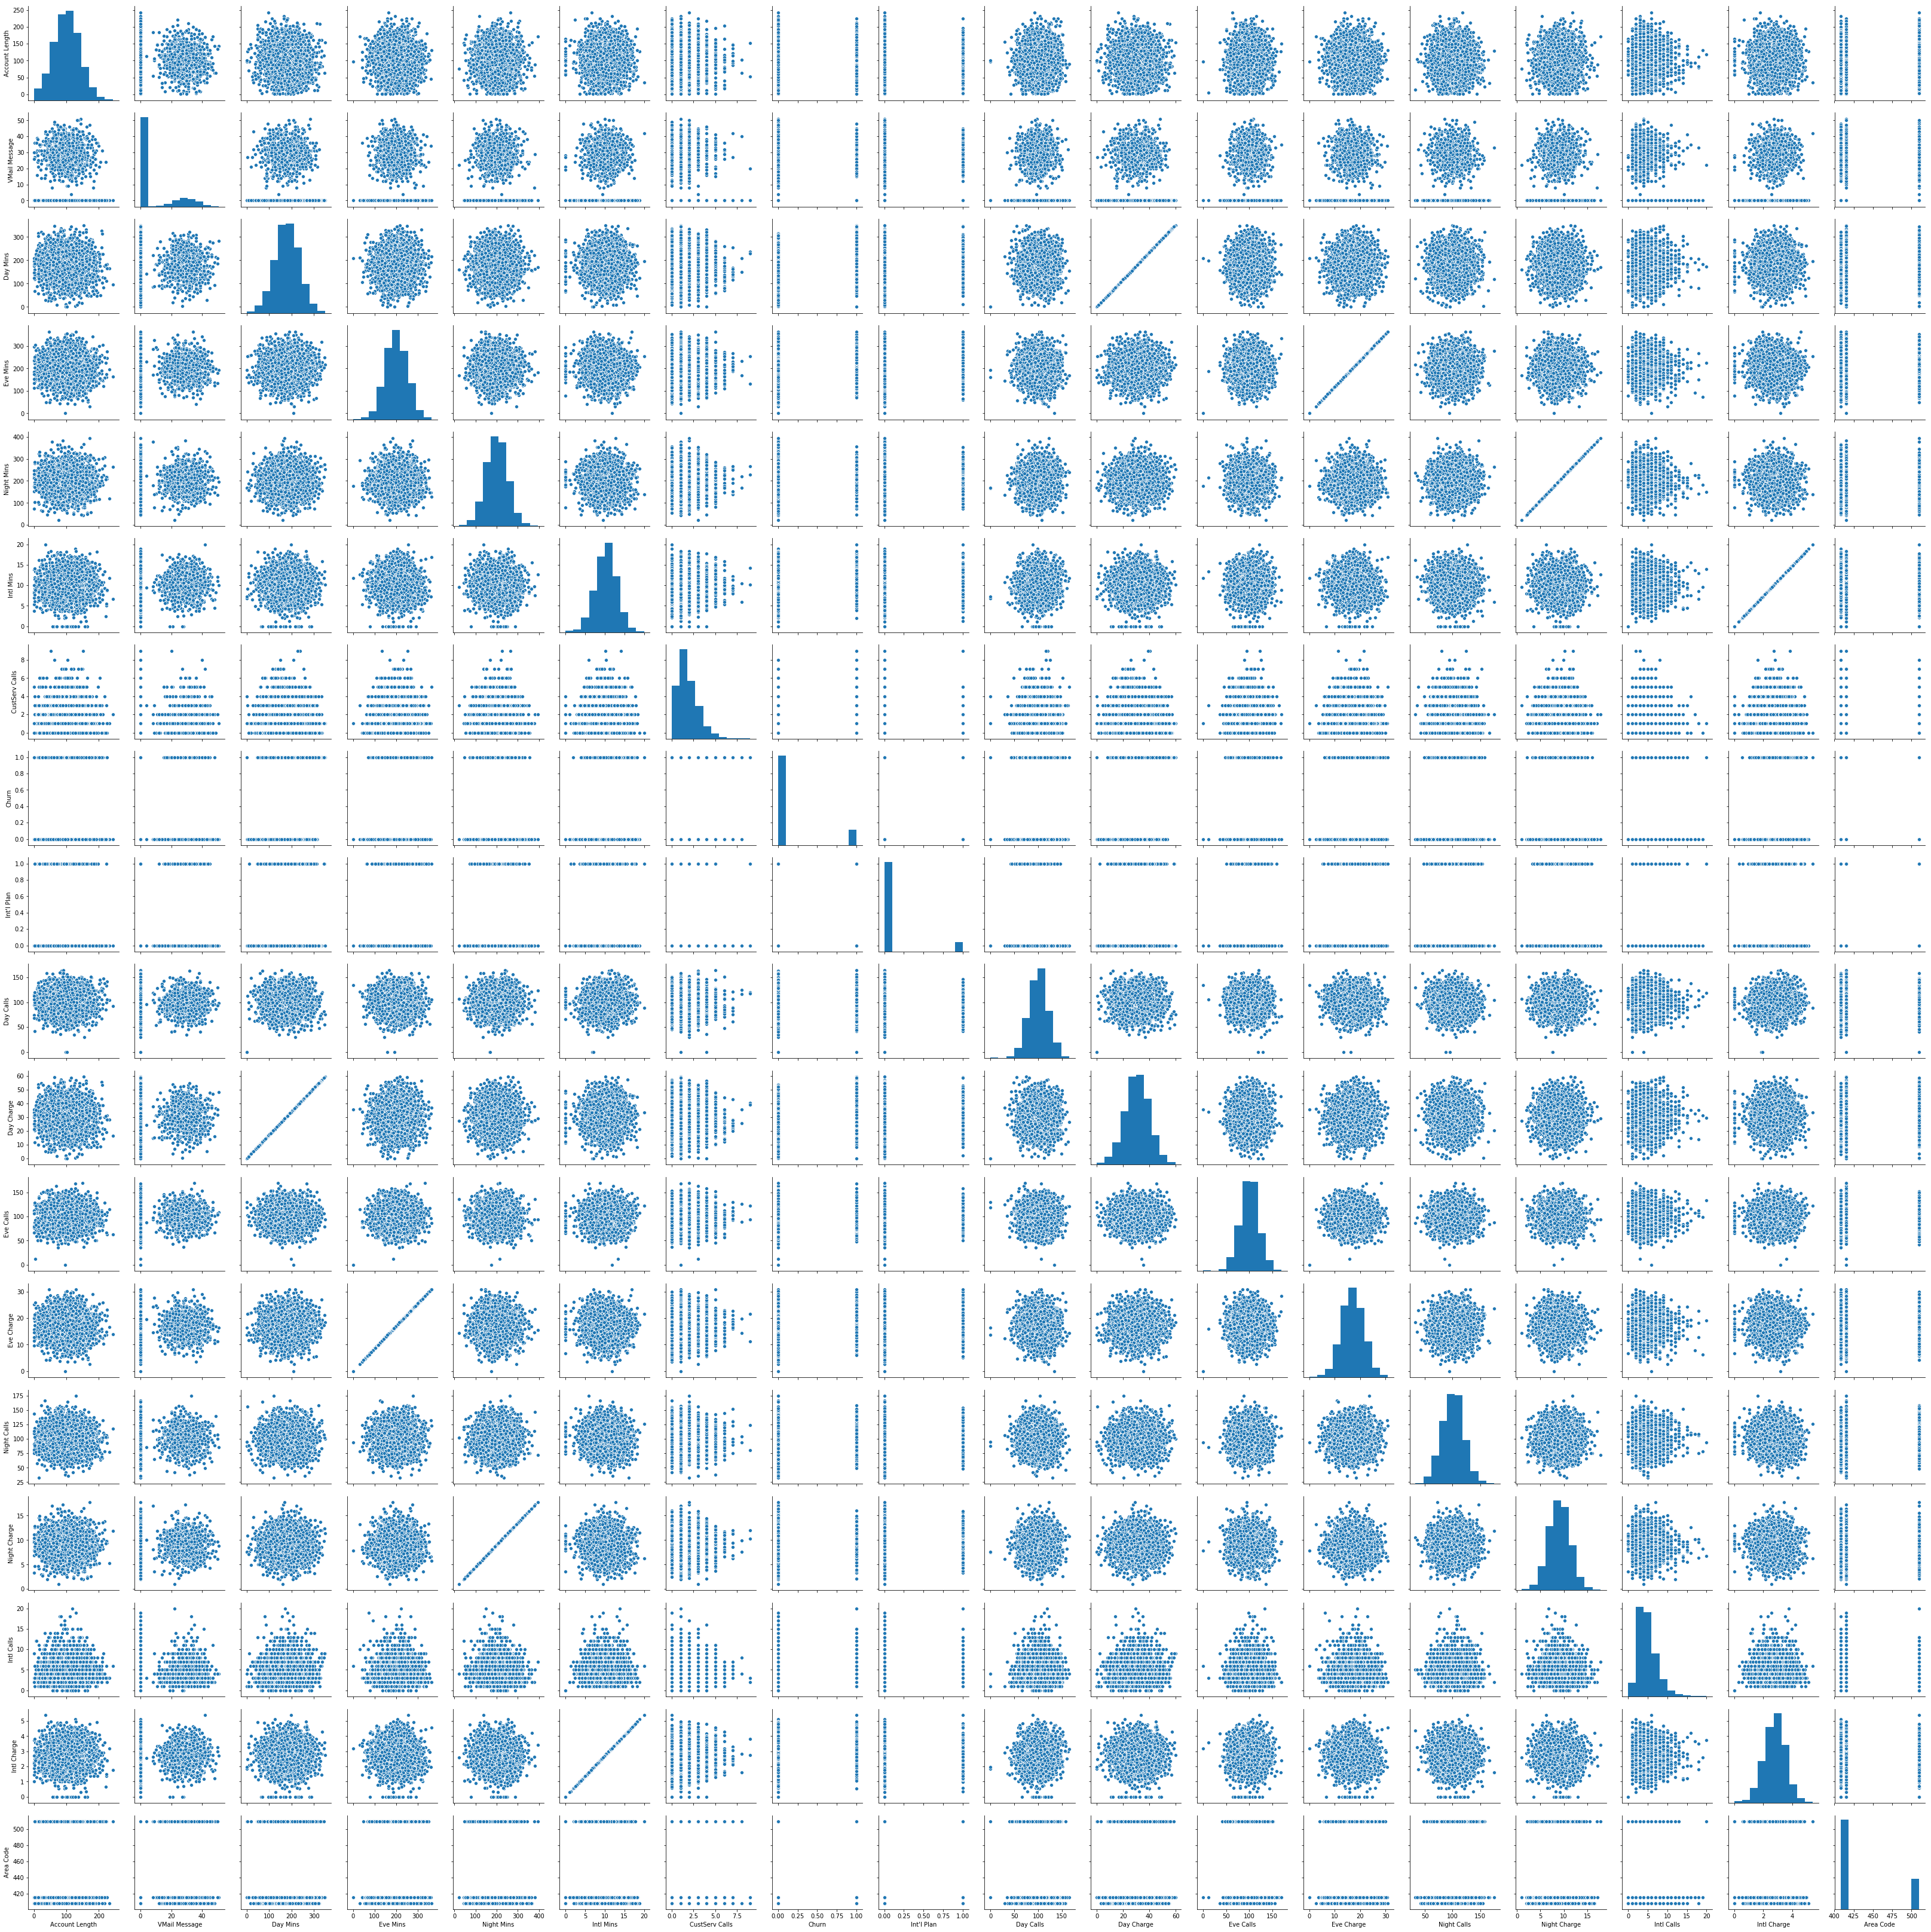

In [12]:
sns.pairplot(data)

We can clearly see linear relationship between Day Charge and Day Mins, Eve Charge and Eve Mins, and Night and Intl Charges and Mins.
Also, we noticed that there are several variables representing same entity:
    e.g. there are Day, Evening,Night and International Calls and Minutes, which can be combined later. 
    Area code, Intl Plan and VMail Msg can be converted into categoricals. 

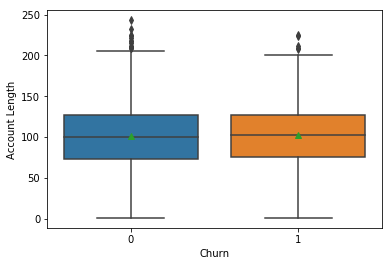

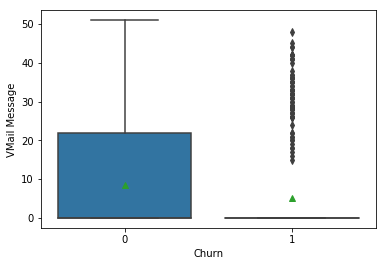

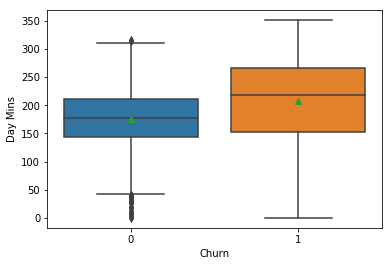

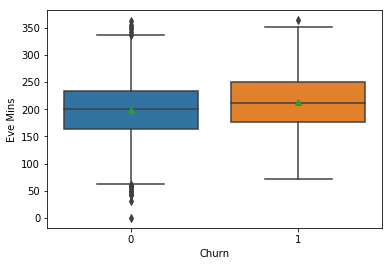

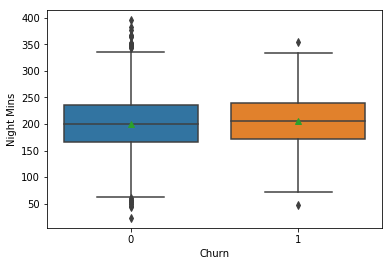

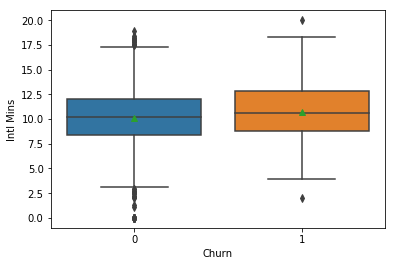

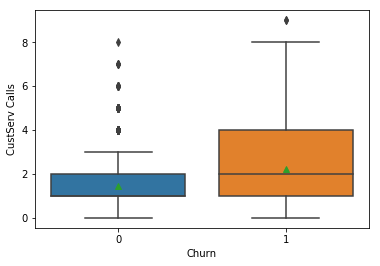

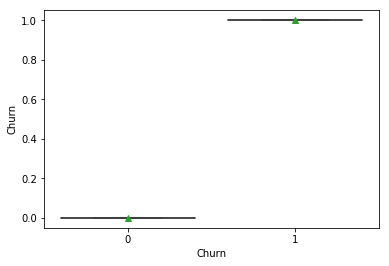

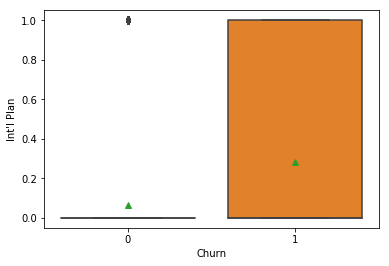

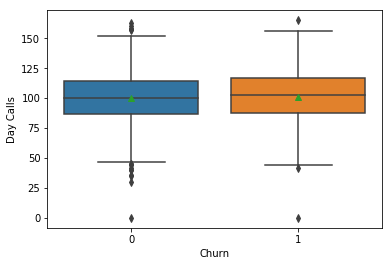

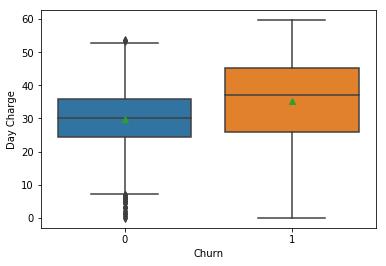

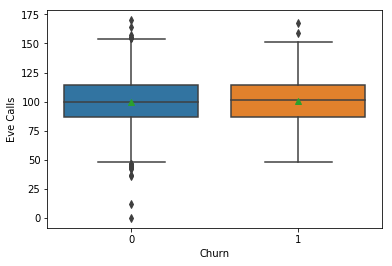

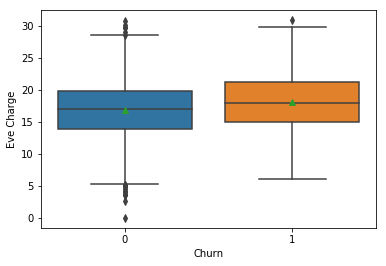

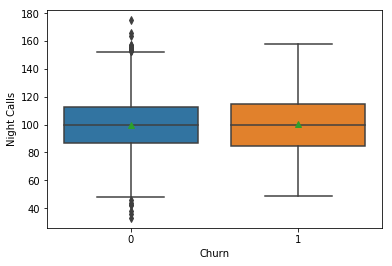

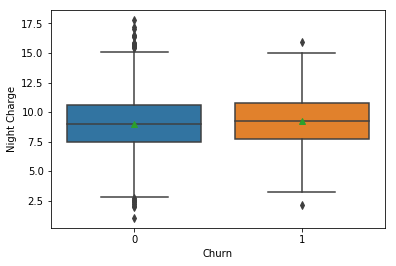

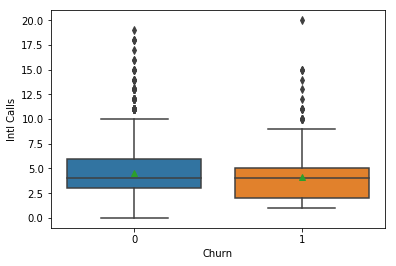

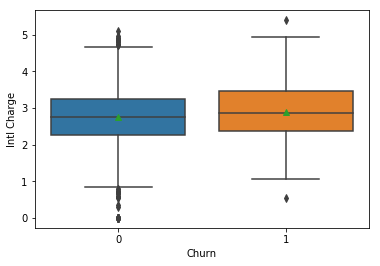

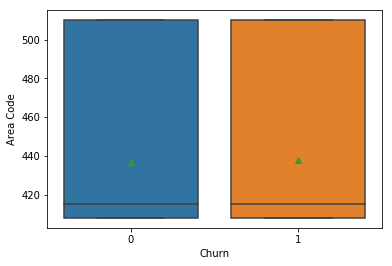

In [25]:
#Let's also see whether mean Churn differs by any of the categorical variables.
#to see that, let's visualize Churn by each categorical variable represented in boxplot.
for i in data.dtypes[data.dtypes!="O"].index.tolist():
    sns.boxplot(data=data,y=i,x="Churn", showmeans=True)
    plt.show()

We can see that all types of minutes, calls and also Area code are not different by number of leaving and staying customers. This will also be taken into account in later transformation.

## Logistic Regression on raw data

In [26]:
#Let's create dummy variables 
data_dum=pd.get_dummies(data,drop_first=True)
#separating X and Y
Y=data_dum["Churn"]
X=data_dum.drop("Churn",axis=1)
#as we are going to use not formula but X and Y data in the logit function, 
#so we need to add the intercept to data (X) manually
X=sm.add_constant(X)
#let's split X and Y data into test and train datasets, test data is 20% of overall data
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.20, random_state=42)

In [27]:
#constructing the logit model
model=Logit(Y0,X0)
#fitting the model
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.324221
         Iterations 7


In [28]:
#predicting for train and test data
Y1_logit=results.predict(sm.add_constant(X1))
Y0_logit=results.predict(X0)

In [29]:
#converting probabilities into labels
Y1_logit=np.where(Y1_logit>=0.5,1,0)
Y0_logit=np.where(Y0_logit>=0.5,1,0)

In [30]:
#calculating classification scores
print("Recall Train on not transformed data:",recall_score(Y0,Y0_logit))
print("Recall Test on not transformed data:",recall_score(Y1,Y1_logit))
print("Accuracy Train on not transformed data:",accuracy_score(Y0,Y0_logit))
print("Accuracy Test on not transformed data:",accuracy_score(Y1,Y1_logit))
print("ROC_AUC Train on not transformed data:",roc_auc_score(Y0,results.predict(X0)))
print("ROC_AUC Test on not transformed data:",roc_auc_score(Y1,results.predict(X1)))

Recall Train on not transformed data: 0.20680628272251309
Recall Test on not transformed data: 0.1485148514851485
Accuracy Train on not transformed data: 0.8627156789197299
Accuracy Test on not transformed data: 0.8500749625187406
ROC_AUC Train on not transformed data: 0.8181510805879278
ROC_AUC Test on not transformed data: 0.8196130567120317


We have quite consistent model in terms of general accuracy and roc_auc score, but we clearly have very low results for recall and overfitting.
Thus let's try transformations and see whether it will improve our model performance.

### Logistic Regression on transformed data

Let's make some transformations, as discussed above.

In [31]:
data.head()

Account Length  VMail Message  Day Mins  Eve Mins  Night Mins  Intl Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ Calls  Churn  Int'l Plan  Day Calls  Day Charge  Eve Calls  \
0               1      0           0        110       45.07         99   
1               1      0           0        123       27.47        103   
2               0      0           0        114       41.38        110   
3               2      0           1         71       50.90         88   
4               3      0           1        113       28.34        122   

   Eve Charge  Night Calls  Night Charge  Intl Calls  Intl Charge  Area Code  
0       16.78           91         11.01           3         2.70        415  
1       16.62          103         11.45           3         3.70        415  
2       10.30          104          7.32           5         3.29        415  
3        5.26           89          8.86           7         1.78        408  
4       12.61          121          8.41           3         2.73        415

In [32]:
#making variables categorical
data["Int'l Plan"]=data["Int'l Plan"].map({0:"0", 1:"1"})
data["VMail Message"]=np.where(data["VMail Message"]==0,"0","other")

In [33]:
#droping variables based on descriptive plots
data.drop(['Account Length','Day Calls','Eve Calls','Night Calls','Intl Calls','Eve Mins','Night Mins','Intl Mins',
          'Night Charge','Intl Charge', 'Area Code'], axis=1, inplace=True)

In [34]:
#creating dummy variables for transformed data
data_tr=pd.get_dummies(data,drop_first=True)
#separating X and Y
Y_tr=data_tr["Churn"]
X_tr=data_tr.drop("Churn",axis=1)
#as we are going to use not formula but X and Y data in the logit function, 
#so we need to add the intercept to data (X) manually
X_tr=sm.add_constant(X_tr)
#splitting the data into train and test sets
X0_tr, X1_tr, Y0_tr, Y1_tr = train_test_split(X_tr, Y_tr, test_size=0.20, random_state=42)

In [35]:
#constructing logit model for transformed data
model_tr=Logit(Y0_tr,X0_tr)
#fitting the model
results_tr=model_tr.fit()

Optimization terminated successfully.
         Current function value: 0.330426
         Iterations 7


In [36]:
#predicting for train and test data
Y1_logit_tr=results_tr.predict(sm.add_constant(X1_tr))
Y0_logit_tr=results_tr.predict(X0_tr)

In [37]:
#converting probabilities into labels
Y1_logit_tr=np.where(Y1_logit_tr>=0.5,1,0)
Y0_logit_tr=np.where(Y0_logit_tr>=0.5,1,0)

In [38]:
print("Recall Train on transformed data:",recall_score(Y0_tr,Y0_logit_tr))
print("Recall Test on transformed data:",recall_score(Y1_tr,Y1_logit_tr))
print("Accuracy Train on transformed data:",accuracy_score(Y0_tr,Y0_logit_tr))
print("Accuracy Test on transformed data:",accuracy_score(Y1_tr,Y1_logit_tr))
print("ROC_AUC Train on transformed data:",roc_auc_score(Y0_tr,results_tr.predict(X0_tr)))
print("ROC_AUC Test on transformed data:",roc_auc_score(Y1_tr,results_tr.predict(X1_tr)))

Recall Train on transformed data: 0.16230366492146597
Recall Test on transformed data: 0.15841584158415842
Accuracy Train on transformed data: 0.8593398349587397
Accuracy Test on transformed data: 0.8500749625187406
ROC_AUC Train on transformed data: 0.8153051961746179
ROC_AUC Test on transformed data: 0.8291816814190253


## Conclusion, selection of the winning model and its interpretation

As already noted, the winning model selection criteria for me is higher recall on testing set. While in case of model on raw data the recall overfits training set, for transformed data it is more reliable, yet not dramatically improved. However, the main reason for such low results on recall is that 1s are only 15% of the data and as we use statsmodels library, we also hadn't a chance to use regularization by tuning hyperparameters via GridSearch, use standard scaler and apply mean cross-validated recall score. 
Therefore, for this case, our winning model is the one based on transformed data.
So let's interpret it using both log-likelihood and marginal effects.

In [39]:
results_tr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2659
Method:                           MLE   Df Model:                            6
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.1958
Time:                        02:31:02   Log-Likelihood:                -880.92
converged:                       True   LL-Null:                       -1095.4
                                        LLR p-value:                 1.620e-89
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.1785      0.391    -15.798      0.000      -6.945      -5.412
Day Mins               -1.8459      3.660     -0.504      0.614      -9.019       5.327
CustServ Calls          0.4996      0.042     11.814      0.000       0.417       0.582
Day Charge             10.9266     21.528      0.508      0.612     -31.268      53.121
Eve Charge              0.0645      0.015      4.400      0.000       0.036       0.093
VMail Message_other    -0.9192      0.162     -5.671      0.000      -1.237      -0.602
Int'l Plan_1            2.0647      0.160     12.943      0.000       1.752       2.377
=======================================================================================
"""

The interpretation will be for significant variables only:
- <b> For a one-unit increase in CustServ Calls we expect on average a 0.4996 increase in the log-odds of churn, holding all other independent variables constant.</b>
- <b> For a one-unit increase in Eve Charge we expect on average a 0.0645 increase in the log-odds of churn, holding all other independent variables constant.</b>
- <b> For customers having VMail Message 0, we expect on average a 0.9192 decrease in the log-odds of churn compared to the customers with 'other' VMail Messages.</b>
- <b> For customers having Int'l Plan 1, we expect on average a 2.0647 increase in the log-odds of churn compared to the customers with Int'l Plan 0.</b>

In [40]:
results_tr.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  Churn
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Day Mins               -0.1827      0.362     -0.504      0.614      -0.893       0.527
CustServ Calls          0.0494      0.004     12.503      0.000       0.042       0.057
Day Charge              1.0816      2.131      0.508      0.612      -3.095       5.258
Eve Charge              0.0064      0.001      4.426      0.000       0.004       0.009
VMail Message_other    -0.0910      0.016     -5.718      0.000      -0.122      -0.060
Int'l Plan_1            0.2044      0.014     14.238      0.000       0.176       0.233
=======================================================================================
"""

The interpretation will be for significant variables only:
- <b> An Incremental increase in CustServ Calls will increase the probability of churn on average by 4.94% when other factors are held constant.</b>
- <b> An Incremental increase in Eve Charge will increase the probability of churn on average by ‭0.64% when other factors are held constant.</b>
- <b> Customers having 0 VMail Message , have on average 9.1% lower probability of churn compared to customers with 'other' VMail Messages.</b>
- <b> Customers having Int'l Plan 1, have on average 20.44% higher probability of churn compared to the customers with Int'l Plan 0.</b>